# **Import Depended Libraries**

In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## **Prepare & download pretrained model from torchvision. FCN segmentation model with resnet backbone chosed for this notebook**

In [2]:
model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
model.eval()

/home/alex/Bureau/OpenClassroom/projet_6/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alex/Bureau/OpenClassroom/projet_6/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /home/alex/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:06<00:00, 21.8MB/s] 


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

### **Let's read an image and show it!**

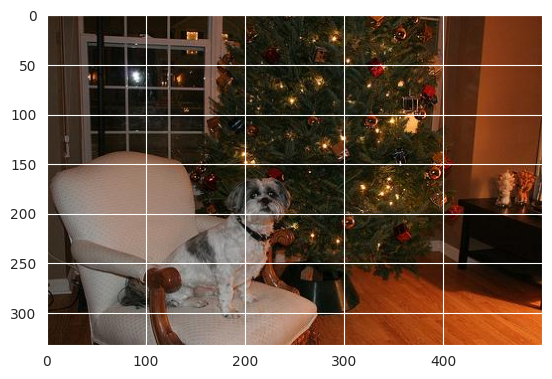

In [3]:
from PIL import Image
img = Image.open('../dataset/Images/n02098413-Lhasa/n02098413_244.jpg')
plt.imshow(img)

## Resize image to 1024,1024 --> H,W

(1024, 1024)

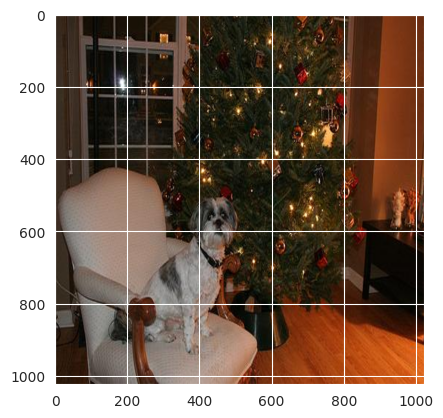

In [4]:
img = img.resize((1024,1024))
plt.imshow(img)
img.size

## The readed image is in format of PIL Jpeg Image we have to convert it to torch Tensor.
## After, we convert tensor to 4D. The provided model takes input as (Batch, C,H,W)

In [5]:
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img = preprocess(img)
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 1024, 1024])

## Lets visualize the image to see for any corruption

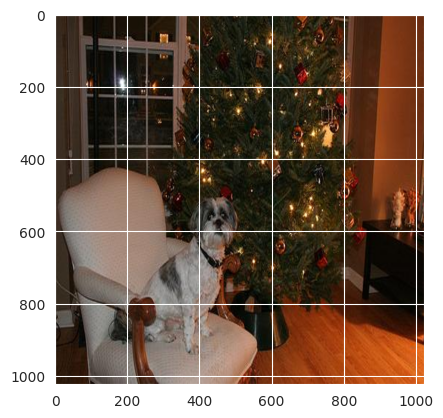

In [6]:
plt.imshow(img[0].permute(1,2,0))

## In this section, we give image into model and take output. We also take the maxiumum arguments inside every probability to have information about class. As you see, we have 21 classes in binary map.

In [7]:
with torch.no_grad():
    output = model(img)['out'][0]
output_predictions = output.argmax(0)
output.shape

torch.Size([21, 1024, 1024])

## We have to convert 21 class binary map to 3 channel rgb to visualize the output. So that we provide a colour palette. And colour palette declared for every class in binary map.

tensor([33554431,    32767,  2097151])

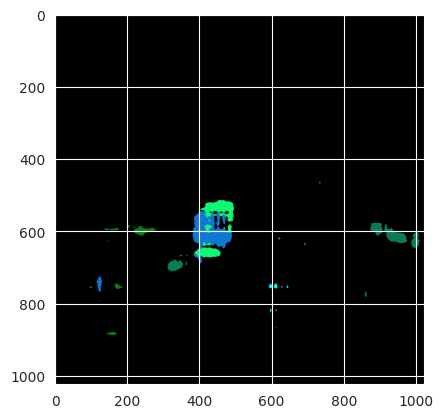

In [8]:
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize((1024,1024))
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)
palette

In [9]:
for param in model.parameters():
    param.requires_grad = False

## The provided model uses 21 classes, have 21 outputs. If we want to retrain & finetune the trained model, we have to change output layers for out purpose. My dataset has 8 classes. ## So I am going to change output from 21 to 8

In [10]:
print('Classifier Section of Model \n',model.classifier)

Classifier Section of Model 
 FCNHead(
  (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1))
)


In [11]:
print('Last layer of section is \n',model.classifier[4])

Last layer of section is 
 Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1))


In [12]:
num_classes = 8 #num classes of my dataset

## To change last layers, we also have to know input of the last layer. So, we take this from provided model.

In [13]:
filters_of_last_layer = model.classifier[4].in_channels
filters_of_last_layer_aux = model.aux_classifier[4].in_channels
model.classifier[4] = nn.Conv2d(filters_of_last_layer,num_classes,kernel_size=(1,1),stride=(1,1))
model.aux_classifier[4] = nn.Conv2d(filters_of_last_layer_aux,num_classes, kernel_size=(1,1),stride=(1,1))

## Now our model is finetuned for my dataset. As you see, "classifier" and "aux_classifier" layers now have 8 classes output

In [14]:
print(model)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

## Let's create a random data with (1,3,1024,1024) shape(B,C,H,W). After, we fit this example data into fintuned model.

In [15]:
x = torch.randn(1, 3, 1024, 1024) #Example input data
y = model(x)
y

OrderedDict([('out',
              tensor([[[[-0.1174, -0.1174, -0.1174,  ..., -0.0988, -0.0988, -0.0988],
                        [-0.1174, -0.1174, -0.1174,  ..., -0.0988, -0.0988, -0.0988],
                        [-0.1174, -0.1174, -0.1174,  ..., -0.0988, -0.0988, -0.0988],
                        ...,
                        [-0.1064, -0.1064, -0.1064,  ..., -0.0242, -0.0242, -0.0242],
                        [-0.1064, -0.1064, -0.1064,  ..., -0.0242, -0.0242, -0.0242],
                        [-0.1064, -0.1064, -0.1064,  ..., -0.0242, -0.0242, -0.0242]],
              
                       [[ 0.1276,  0.1276,  0.1276,  ...,  0.1567,  0.1567,  0.1567],
                        [ 0.1276,  0.1276,  0.1276,  ...,  0.1567,  0.1567,  0.1567],
                        [ 0.1276,  0.1276,  0.1276,  ...,  0.1567,  0.1567,  0.1567],
                        ...,
                        [ 0.1025,  0.1025,  0.1025,  ...,  0.1395,  0.1395,  0.1395],
                        [ 0.1025,  0.1025,  0

## Now, you can see that the model is give output for 8 classes. Now it is ready to Train my dataset :)

In [16]:
y['out'].shape

torch.Size([1, 8, 1024, 1024])